# 1. Imports & Setup

In [3]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import pandas as pd

device = torch.device("cpu")
print("Using device:", device)

os.makedirs("models", exist_ok=True)

# Reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

Using device: cpu


# 2. Dataset & Data Augmentation

In [7]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST("data", train=True, download=True, transform=train_transform)
test_dataset  = datasets.MNIST("data", train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=1000, shuffle=False)

print("Training samples:", len(train_dataset))
print("Test samples:", len(test_dataset))

Training samples: 60000
Test samples: 10000


# 3. Visualize Sample Images

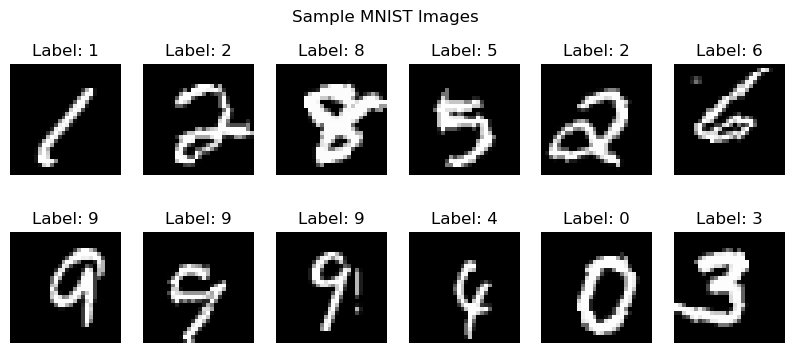

In [13]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig, axes = plt.subplots(2, 6, figsize=(10, 4))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(example_data[i][0], cmap="gray")
    ax.set_title(f"Label: {example_targets[i].item()}")
    ax.axis("off")

plt.suptitle("Sample MNIST Images")
plt.show()

# 4. Visualize Class Distribution

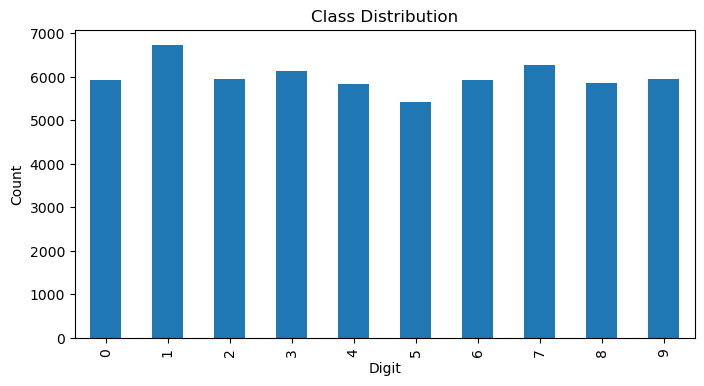

In [18]:
labels = train_dataset.targets.numpy()

plt.figure(figsize=(8,4))
pd.Series(labels).value_counts().sort_index().plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Digit")
plt.ylabel("Count")
plt.show()

# 5. CNN Model

In [23]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout(0.5)

        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

# 6. LeNet-5 Model

In [27]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.AvgPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x)) 
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 7. Training & Evaluation Functions

In [32]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total, correct, loss_sum = 0, 0, 0

    for data, target in loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item() * data.size(0)
        correct += (output.argmax(1) == target).sum().item()
        total += data.size(0)

    return loss_sum/total, 100 * correct / total


def evaluate(model, loader, criterion):
    model.eval()
    total, correct, loss_sum = 0, 0, 0

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = criterion(output, target)

            loss_sum += loss.item() * data.size(0)
            correct += (output.argmax(1) == target).sum().item()
            total += data.size(0)

    return loss_sum/total, 100 * correct / total

# 8. Train CNN

In [36]:
cnn_model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

cnn_train_loss, cnn_train_acc = [], []
cnn_val_loss, cnn_val_acc = [], []

EPOCHS = 10

for epoch in range(1, EPOCHS+1):
    tl, ta = train_one_epoch(cnn_model, train_loader, optimizer, criterion)
    vl, va = evaluate(cnn_model, test_loader, criterion)

    cnn_train_loss.append(tl)
    cnn_train_acc.append(ta)
    cnn_val_loss.append(vl)
    cnn_val_acc.append(va)

    print(f"Epoch {epoch}/{EPOCHS} | CNN Train Acc: {ta:.2f}% | Val Acc: {va:.2f}%")

# Save model
torch.save(cnn_model.state_dict(), "models/cnn_model.pt")
print("CNN model saved.")

Epoch 1/10 | CNN Train Acc: 85.34% | Val Acc: 98.28%
Epoch 2/10 | CNN Train Acc: 92.96% | Val Acc: 98.83%
Epoch 3/10 | CNN Train Acc: 94.55% | Val Acc: 99.09%
Epoch 4/10 | CNN Train Acc: 95.01% | Val Acc: 99.09%
Epoch 5/10 | CNN Train Acc: 95.66% | Val Acc: 99.28%
Epoch 6/10 | CNN Train Acc: 95.88% | Val Acc: 99.13%
Epoch 7/10 | CNN Train Acc: 96.20% | Val Acc: 99.20%
Epoch 8/10 | CNN Train Acc: 96.29% | Val Acc: 99.20%
Epoch 9/10 | CNN Train Acc: 96.61% | Val Acc: 99.23%
Epoch 10/10 | CNN Train Acc: 96.65% | Val Acc: 99.35%
CNN model saved.


# 9. Train LeNet-5

In [39]:
lenet_model = LeNet5().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet_model.parameters(), lr=0.001)

lenet_train_loss, lenet_train_acc = [], []
lenet_val_loss, lenet_val_acc = [], []

EPOCHS = 10

for epoch in range(1, EPOCHS+1):
    tl, ta = train_one_epoch(lenet_model, train_loader, optimizer, criterion)
    vl, va = evaluate(lenet_model, test_loader, criterion)

    lenet_train_loss.append(tl)
    lenet_train_acc.append(ta)
    lenet_val_loss.append(vl)
    lenet_val_acc.append(va)

    print(f"Epoch {epoch}/{EPOCHS} | LeNet5 Train Acc: {ta:.2f}% | Val Acc: {va:.2f}%")

# Save model
torch.save(lenet_model.state_dict(), "models/lenet5_model.pt")
print("LeNet-5 model saved.")


Epoch 1/10 | LeNet5 Train Acc: 83.55% | Val Acc: 96.14%
Epoch 2/10 | LeNet5 Train Acc: 94.44% | Val Acc: 97.23%
Epoch 3/10 | LeNet5 Train Acc: 96.00% | Val Acc: 96.41%
Epoch 4/10 | LeNet5 Train Acc: 96.59% | Val Acc: 97.81%
Epoch 5/10 | LeNet5 Train Acc: 97.06% | Val Acc: 98.49%
Epoch 6/10 | LeNet5 Train Acc: 97.40% | Val Acc: 98.51%
Epoch 7/10 | LeNet5 Train Acc: 97.73% | Val Acc: 98.81%
Epoch 8/10 | LeNet5 Train Acc: 97.83% | Val Acc: 98.81%
Epoch 9/10 | LeNet5 Train Acc: 98.10% | Val Acc: 99.02%
Epoch 10/10 | LeNet5 Train Acc: 98.13% | Val Acc: 99.07%
LeNet-5 model saved.


# 9. Loss Curves (CNN vs LeNet-5)

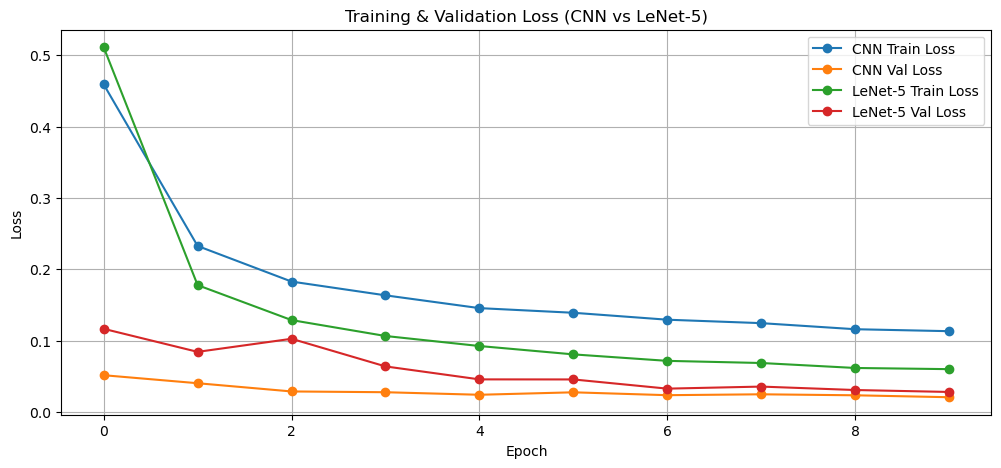

In [46]:
plt.figure(figsize=(12,5))

plt.plot(cnn_train_loss, label="CNN Train Loss", marker='o')
plt.plot(cnn_val_loss, label="CNN Val Loss", marker='o')

plt.plot(lenet_train_loss, label="LeNet-5 Train Loss", marker='o')
plt.plot(lenet_val_loss, label="LeNet-5 Val Loss", marker='o')

plt.title("Training & Validation Loss (CNN vs LeNet-5)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

# 10. Accuracy Curves (CNN vs LeNet-5)

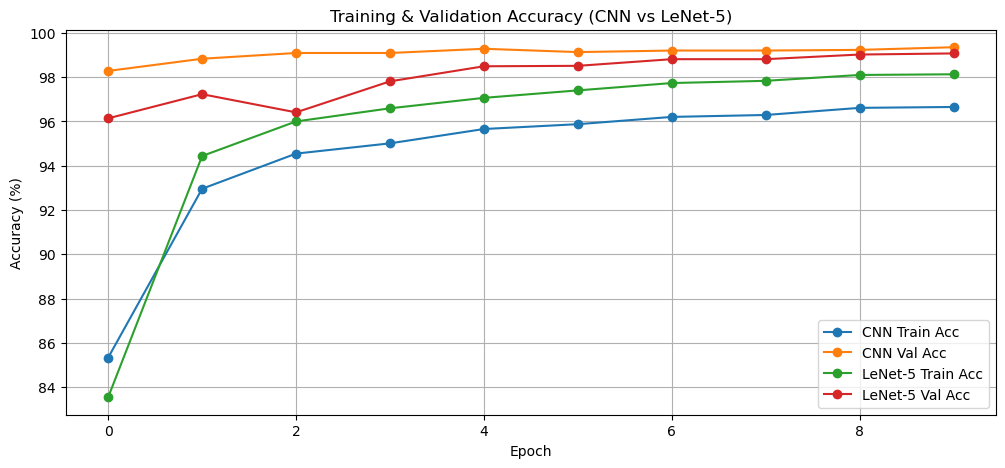

In [51]:
plt.figure(figsize=(12,5))

plt.plot(cnn_train_acc, label="CNN Train Acc", marker='o')
plt.plot(cnn_val_acc, label="CNN Val Acc", marker='o')

plt.plot(lenet_train_acc, label="LeNet-5 Train Acc", marker='o')
plt.plot(lenet_val_acc, label="LeNet-5 Val Acc", marker='o')

plt.title("Training & Validation Accuracy (CNN vs LeNet-5)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()
plt.show()

# 11. Confusion Matrix & Report

## CNN Model


CNN Classification Report:

              precision    recall  f1-score   support

           0     0.9939    0.9980    0.9959       980
           1     0.9921    0.9982    0.9952      1135
           2     0.9961    0.9903    0.9932      1032
           3     0.9931    0.9970    0.9951      1010
           4     0.9959    0.9908    0.9934       982
           5     0.9933    0.9922    0.9927       892
           6     0.9937    0.9906    0.9922       958
           7     0.9913    0.9951    0.9932      1028
           8     0.9948    0.9908    0.9928       974
           9     0.9911    0.9911    0.9911      1009

    accuracy                         0.9935     10000
   macro avg     0.9935    0.9934    0.9935     10000
weighted avg     0.9935    0.9935    0.9935     10000



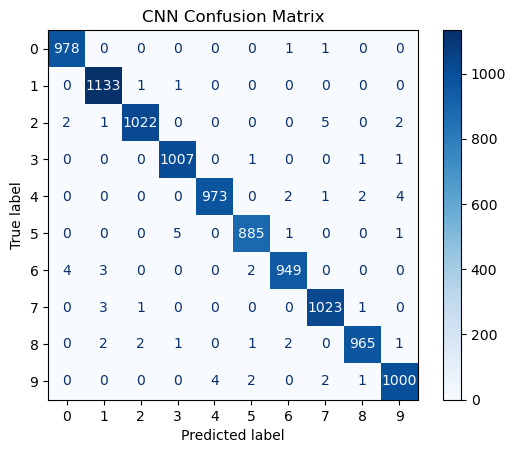

In [80]:
def evaluate_full(model, name):
    model.eval()
    preds, labels = [], []

    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            preds.extend(output.argmax(1).cpu().numpy())
            labels.extend(target.cpu().numpy())

    print(f"\n{name} Classification Report:\n")
    print(classification_report(labels, preds, digits=4))

    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.show()

evaluate_full(cnn_model, "CNN")

## LeNet-5 Model


LeNet-5 Classification Report:

              precision    recall  f1-score   support

           0     0.9949    0.9980    0.9964       980
           1     0.9947    0.9938    0.9943      1135
           2     0.9913    0.9913    0.9913      1032
           3     0.9834    0.9970    0.9902      1010
           4     0.9939    0.9878    0.9908       982
           5     0.9888    0.9922    0.9905       892
           6     0.9947    0.9823    0.9884       958
           7     0.9902    0.9864    0.9883      1028
           8     0.9938    0.9877    0.9907       974
           9     0.9813    0.9901    0.9857      1009

    accuracy                         0.9907     10000
   macro avg     0.9907    0.9906    0.9907     10000
weighted avg     0.9907    0.9907    0.9907     10000



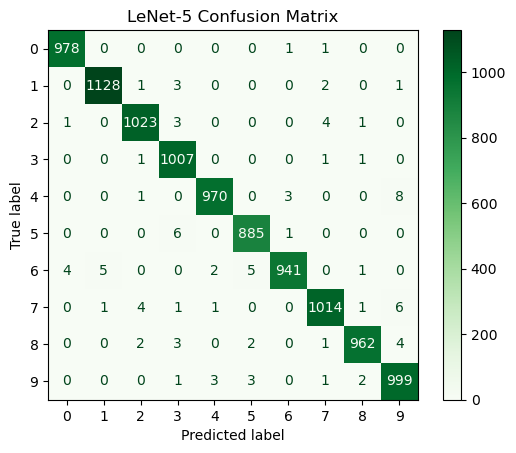

In [83]:
def evaluate_full(model, name):
    model.eval()
    preds, labels = [], []

    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            preds.extend(output.argmax(1).cpu().numpy())
            labels.extend(target.cpu().numpy())

    print(f"\n{name} Classification Report:\n")
    print(classification_report(labels, preds, digits=4))

    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Greens')
    plt.title(f"{name} Confusion Matrix")
    plt.show()

evaluate_full(lenet_model, "LeNet-5")

# 12. Load Saved Models & Predict

## Load Saved CNN Model

In [92]:
cnn_model_loaded = SimpleCNN().to(device)
cnn_model_loaded.load_state_dict(torch.load("models/cnn_model.pt", map_location=device))
cnn_model_loaded.eval()

print("CNN model loaded successfully!")

CNN model loaded successfully!


## Show CNN redictions

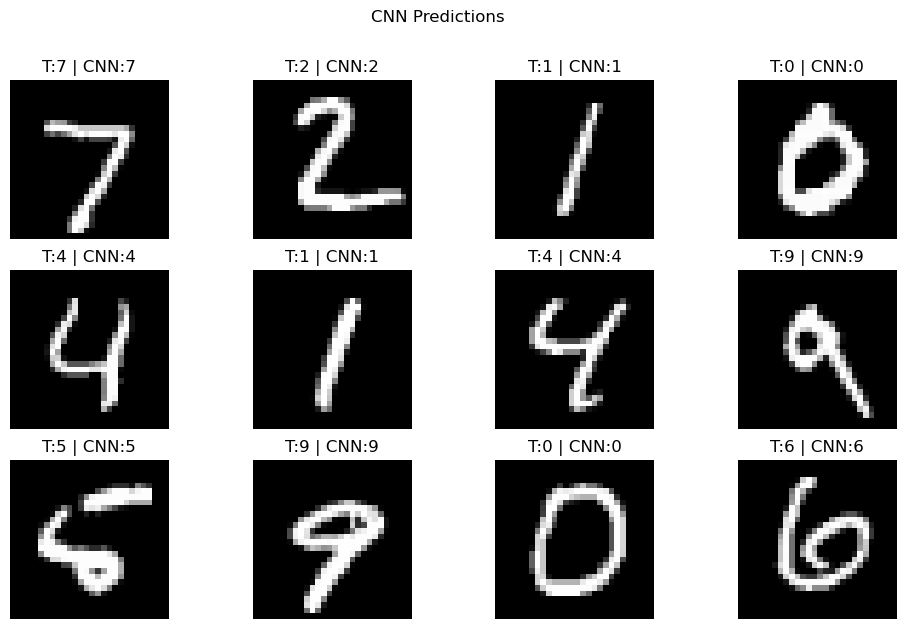

In [95]:
images, labels = next(iter(test_loader))
with torch.no_grad():
    preds = cnn_model_loaded(images).argmax(1)

fig, axes = plt.subplots(3, 4, figsize=(12, 7))
axes = axes.flatten()

for i in range(12):
    axes[i].imshow(images[i][0], cmap='gray')
    axes[i].set_title(f"T:{labels[i].item()} | CNN:{preds[i].item()}")
    axes[i].axis("off")

plt.suptitle("CNN Predictions")
plt.show()

## Load saved LeNet-5 model

In [101]:
lenet5_model_loaded = LeNet5().to(device)
lenet5_model_loaded.load_state_dict(torch.load("models/lenet5_model.pt", map_location=device))
lenet5_model_loaded.eval()

print("LeNet-5 model loaded successfully!")

LeNet-5 model loaded successfully!


## Show LeNet-5 Predictions

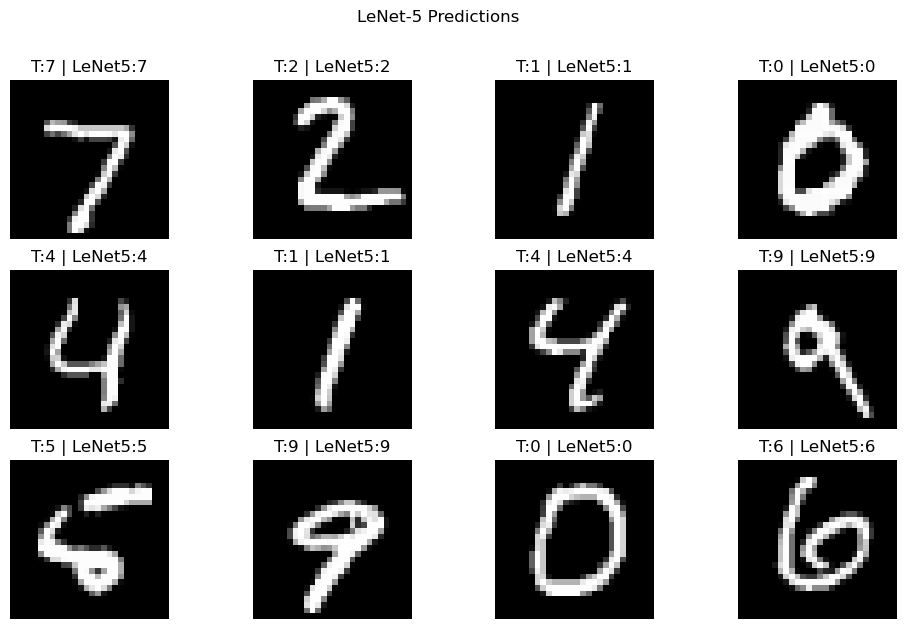

In [107]:
with torch.no_grad():
    preds = lenet5_model_loaded(images).argmax(1)

fig, axes = plt.subplots(3, 4, figsize=(12, 7))
axes = axes.flatten()

for i in range(12):
    axes[i].imshow(images[i][0], cmap='gray')
    axes[i].set_title(f"T:{labels[i].item()} | LeNet5:{preds[i].item()}")
    axes[i].axis("off")

plt.suptitle("LeNet-5 Predictions")
plt.show()

## Predict CNN model

In [131]:
# Predict full test set using saved CNN model
cnn_all_preds = []
cnn_all_labels = []

with torch.no_grad():
    for data, target in test_loader:
        output = cnn_model_loaded(data)
        preds = output.argmax(1)

        cnn_all_preds.extend(preds.cpu().numpy())
        cnn_all_labels.extend(target.cpu().numpy())

# Accuracy
cnn_correct = sum(np.array(cnn_all_preds) == np.array(cnn_all_labels))
cnn_accuracy = cnn_correct / len(cnn_all_labels) * 100

print(f"CNN Full Test Accuracy: {cnn_accuracy:.2f}%")

CNN Full Test Accuracy: 99.35%


## Predict LeNet-5 model

In [135]:
# Predict full test set using saved LeNet-5 model
lenet_preds = []
lenet_labels = []

with torch.no_grad():
    for data, target in test_loader:
        output = lenet5_model_loaded(data)
        preds = output.argmax(1)

        lenet_preds.extend(preds.cpu().numpy())
        lenet_labels.extend(target.cpu().numpy())

# Accuracy
lenet_correct = sum(np.array(lenet_preds) == np.array(lenet_labels))
lenet_accuracy = lenet_correct / len(lenet_labels) * 100

print(f"LeNet-5 Full Test Accuracy: {lenet_accuracy:.2f}%")

LeNet-5 Full Test Accuracy: 99.07%


# 13. Determine Best Model

In [147]:
print("MODEL COMPARISON")
print(f" - CNN Accuracy:     {cnn_accuracy:.2f}%")
print(f" - LeNet-5 Accuracy: {lenet_accuracy:.2f}%")

if cnn_accuracy > lenet_accuracy:
    print("\nBest Model: CNN")
else:
    print("\nBest Model: LeNet-5")

MODEL COMPARISON
 - CNN Accuracy:     99.35%
 - LeNet-5 Accuracy: 99.07%

Best Model: CNN
